In [1]:
import pandas as pd
import psycopg2
import numpy as np
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from PlotWords import plot_word

In [3]:
def selectMatrix(withPearson,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT m.subject_id,m.word,1 as Counting,s.isalive "
                      " FROM matrix m LEFT JOIN subjectwords s ON m.subject_id=s.subject_id"
    )
    if withPearson:
        select_stament = select_stament+" WHERE m.word in (select word from wordspearson order by p2 desc limit 400)"
    cur.execute(select_stament)
    select = []
    for row in cur :
        select.append((row))
    cur.close()
    conn.close()
    return select

In [4]:
def convertMatrix(withPearson=False) :
    labels = ['subject_id', 'Word', 'Counting','isAlive']
    df = pd.DataFrame.from_records(selectMatrix(withPearson), columns=labels)
    print(len(df))
    table = pd.pivot_table(df,index=["subject_id","isAlive"],columns=["Word"],values=["Counting"],
                       aggfunc={"Counting":[np.sum]},fill_value=0)
    table.columns = [value[2] for value in table.columns.values]
    return table

In [5]:
def savePearson(pearson,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    insert_statement=('INSERT INTO wordspearson(word,p1,p2)'
                      ' SELECT unnest( %(word)s ) ,'
                      ' unnest( %(p1)s) ,'
                      ' unnest( %(p2)s)')
    word=[r['word'] for r in pearson]
    p1=[r['p1'] for r in pearson]
    p2=[r['p2'] for r in pearson]
#    print(cur.mogrify(insert_statement,locals()))
    cur.execute(insert_statement,locals())
    conn.commit()
    cur.close()
    conn.close()

In [6]:
def selectPearson(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='SELECT word,p1,p2 FROM wordspearson'
#    print(cur.mogrify(delete_statement,locals()))
    cur.execute(select_statement)
    select = []
    for row in cur :
        select.append({"word":row[0],"p1":row[1],"p2":row[2],})
    cur.close()
    conn.close()
    return select

In [7]:
def cleanPearson(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    delete_statement='DELETE FROM wordspearson'
#    print(cur.mogrify(delete_statement,locals()))
    cur.execute(delete_statement,locals())
    conn.commit()
    cur.close()
    conn.close()

In [8]:
table = convertMatrix()
print(table.shape)
table

134706
(658, 5610)


,,aaaae,aaaah,aaaai,aaaaj,aaabe,aaabf,aaabg,aaabh,aaabi,aaabj,...,lbbbb,lbbcb,lbcbb,leeee,libbb,liiii,liiil,liili,lilii,lliii
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
85,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
177,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214,1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
279,1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
283,1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
368,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
377,1,1,1,0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
408,1,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
survived = table.index.labels[1].tolist()
patients = table.values
columns = list(table.columns.values)

In [10]:
cleanPearson()
pearsonList = []
for i in range(len(columns)):
    pearson = pearsonr(patients[:,i],survived)
    pearsonList.append({'word':columns[i],'p1':pearson[0],'p2':pearson[1]})
savePearson(pearsonList)

In [11]:
table = convertMatrix(True)
table.shape

10108


(624, 400)

In [12]:
survived = table.index.labels[1].tolist()
patients = table.values

In [13]:
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)

In [14]:
print(table.shape)
print(patients_train.shape)
print(patients_test.shape)

(624, 400)
(499, 400)
(125, 400)


In [15]:
model = ajustLogisticRegression(patients_train,survived_train,patients_test,survived_test)

acurracy is 74.40%


In [16]:
print("Logistic Regression acurracy is %2.2f" % accuracy_score(survived_test,model.predict(patients_test)))

Logistic Regression acurracy is 0.74


In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [18]:
def aucModel(name,survived_test,model,patients_test):
    logit_roc_auc = roc_auc_score(survived_test,model.predict(patients_test))
    print(name+" AUC = %2.2f"% logit_roc_auc)
    return logit_roc_auc

In [19]:
print("Logistic Regression acurracy is %2.2f" % accuracy_score(survived_test,model.predict(patients_test)))
logit_roc_auc = aucModel("Logistic",survived_test,model,patients_test)

Logistic Regression acurracy is 0.74
Logistic AUC = 0.50


In [20]:
model

LogisticRegressionCV(Cs=[4.51e-05, 4.672e-05, 4.8339999999999995e-05, 4.9959999999999996e-05, 5.157999999999999e-05, 5.319999999999999e-05],
           class_weight=None, cv=5, dual=True, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=0, refit=True,
           scoring='roc_auc', solver='liblinear', tol=0.0001, verbose=0)

In [21]:
from operator import itemgetter
pearsonDict = selectPearson()
pearsonDict = sorted(pearsonDict, key=itemgetter('p1'), reverse=True)

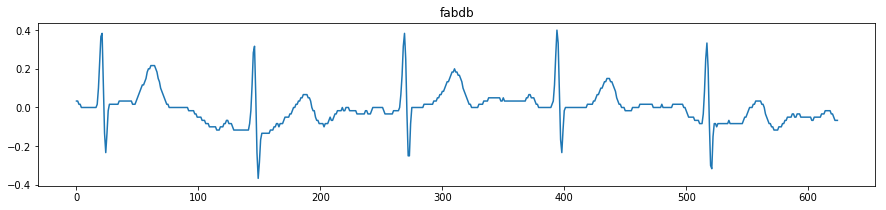

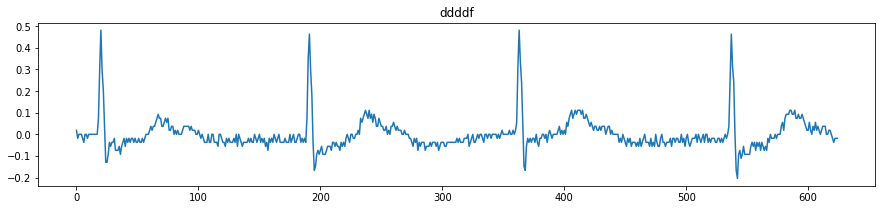

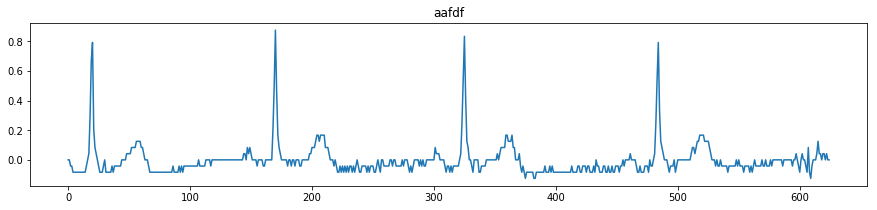

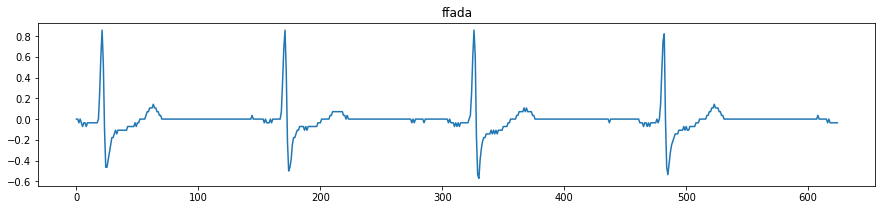

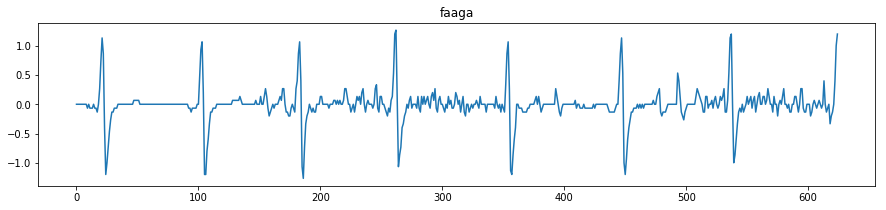

In [22]:
plot_word(pearsonDict[:5])